# 1. Setup

In [2]:
from lightgbm import LGBMRegressor, plot_tree
import plotly.express as px
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

from utils import *

# 2. Prepare data

## 2.1. Load data

In [3]:
trips = pd.read_parquet('../data/trips.parquet').disp()

747,088 rows x 21 cols; Memory: 34.9 MiB


Distance       Time      Speed     Weight     Purpose        Mode  \
   <float64>  <float64>  <float64>  <float64>  <category>  <category>   
0   8.439379  16.182075  31.291583        0.5         HBO       Drive   

      Weekend    GasPrice    StayTime   StartTime  ...     ODUrban  \
   <category>  <category>  <category>  <category>  ...  <category>   
0          No         Low         Mid    Off-peak  ...       S → S   

          Age         Sex        Race    Hispanic   Education      Worker  \
   <category>  <category>  <category>  <category>  <category>  <category>   
0      Senior      Female   Non-White          No     College          No   

       Income     HomeOwn      VehOwn  
   <category>  <category>  <category>  
0         Mid         Own        High  

[2 rows x 21 columns]

In [4]:
col_groups = []
for grp, start, end, color in [
        ('Trip', 'Purpose', 'ODUrban', 'deepskyblue'),
        ('Traveler', 'Age', 'VehOwn', 'hotpink')]:
    df = Pdf(D(factor=trips.loc[:, start: end].columns))
    col_groups.append(df.assign(group=grp, color=color))
col_groups = pd.concat(col_groups).reset_index(drop=1).disp()

17 rows x 3 cols; Memory: 0.0 MiB


factor     group        color
   <object>  <object>     <object>
0   Purpose      Trip  deepskyblue

# 3. Distributions

## 3.1. Interactive distributions

In [5]:
def plot_distr_vars(data=trips, width=1600, height=500):
    res = []
    for target, vmin, vmax in [('Time', 0, 90),
                               ('Distance', 0, 100),
                               ('Speed', 0, 80)]:
        for var in data.select_dtypes(CAT):
            for cat, df in data.groupby(var):
                vals = df[target].clip(vmin, vmax)
                y, x = np.histogram(vals, bins=100, weights=df.Weight)
                y = (y / y.sum()).cumsum()
                res.append(Pdf(D(value=x[1:], density=y))
                           .assign(var=var, cat=cat, target=target))
    res = pd.concat(res).reset_index(drop=1)
    fig = px.line(res, x='value', y='density', color='var', facet_col='target',
                  width=width, height=height, hover_name='cat', hover_data=['cat'],
                  labels=D(density='Cumulative probability density', var='Factor'))
    fig.update_layout(hoverlabel=D(bgcolor='white', font_size=16),
                      font=D(family='Arial', size=18))
    fig.for_each_xaxis(lambda x: x.update(matches=None))
    fig.show()

plot_distr_vars() # t=0:05

## 3.2. Variable-wise histogram

In [6]:
def get_var_hist(data=trips, max_vals=D(Distance=100, Time=120)):
    res = []
    for col in data.select_dtypes(CAT).columns:
        for var, df in data.groupby(col):
            for target, vmax in max_vals.items():
                y = df[target].clip(0, vmax)
                y, x = np.histogram(y, bins=np.arange(0, vmax + 1))
                y = (1 - (y / y.sum()).cumsum()).clip(0)
                res.append(D(target=target, factor=col,
                             level=var, x=x[1:], y=y))
    res = Pdf(res)
    return res

var_hist = get_var_hist().disp() # t=0:02

98 rows x 5 cols; Memory: 0.1 MiB


target    factor     level  \
   <object>  <object>  <object>   
0  Distance   Purpose       HBW   

                                                   x  \
                                            <object>   
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                                   y  
                                            <object>  
0  [0.9612716872850274, 0.9134028846702013, 0.863...

# 4. Fit curves

## 4.1. Select functional form

In [7]:
imped_funcs = {
    'Power': lambda x, a: x ** a,
    'Base exponential': lambda x, a: np.exp(a * x),
    'Sherratt Tanner': lambda x, a: np.exp(-a * (x ** 2)),
    'Logistic': lambda x, a: 2 * (1 + np.exp(a * x)) ** (-1),
    'Power exponential': lambda x, a, b: np.exp(-a * (x ** b)),
    'Tanner': lambda x, a, b: (x ** a) * np.exp(b * x),
    'Quadratic exponential': lambda x, a, b: np.exp(a * x - b * (x ** 2)),
    # 'Cubic exponential': lambda x, a, b, c: np.exp(-a * x + b * (x ** 2) - c * (x ** 3)),
}

In [8]:
def fit_decay_functions(funcs=imped_funcs, hists=var_hist):
    res = []
    for _, r in hists.iterrows():
        for fname, func in funcs.items():
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    params = curve_fit(func, r.x, r.y)[0]
                yfit = func(r.x, *params).clip(0, 1)
                r2 = r2_score(r.y, yfit)
                if r2 < 0 or r2 > 1: continue
            except RuntimeError as e:
                print('ERROR:', fname, r, e)
                continue
            res.append(D(target=r.target, factor=r.factor, 
                         level=r.level, func=fname,
                         r2=r2, params=list(params)))
    res = Pdf(res)
    return res

fitted = fit_decay_functions().disp()
# x = fit_decay_functions(); x

685 rows x 6 cols; Memory: 0.2 MiB


target    factor     level      func         r2                 params
   <object>  <object>  <object>  <object>  <float64>               <object>
0  Distance   Purpose       HBW     Power   0.707913  [-0.4892477188849867]

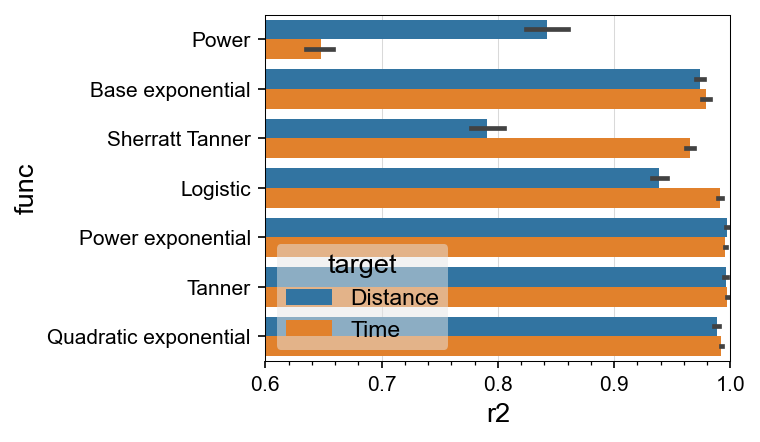

In [9]:
ax = pplot(size=(4, 3), dpi=150, yminor=0, xlim=(0.6, 1))
sns.barplot(fitted, y='func', x='r2', hue='target', ax=ax);

In [10]:
(fitted.groupby(['func', 'target'])['r2'].describe()
 .reset_index().melt(['func', 'target'])
 .assign(statistic=lambda df: pd.Categorical(
     df.variable, categories=['mean', 'std', 'min', 'max']))
 .pivot_table('value', 'func', ['target', 'statistic'])
 .loc[list(imped_funcs.keys())].reset_index())

target                      func  Distance                                \
statistic                             mean       std       min       max   
0                          Power  0.842544  0.059991  0.612593  0.939323   
1               Base exponential  0.973845  0.011411  0.947491  0.999716   
2                Sherratt Tanner  0.790781  0.052783  0.709684  0.949013   
3                       Logistic  0.938839  0.023402  0.897155  0.996552   
4              Power exponential  0.997039  0.002376  0.987333  0.999830   
5                         Tanner  0.995990  0.004006  0.973517  0.999789   
6          Quadratic exponential  0.988206  0.007246  0.962058  0.999937   

target         Time                                
statistic      mean       std       min       max  
0          0.647699  0.040442  0.476779  0.726955  
1          0.978994  0.011730  0.927372  0.997833  
2          0.965366  0.013154  0.903767  0.991164  
3          0.991245  0.005470  0.966542  0.995715  
4          0.995556  0.001207  0.992032  0.998709  
5          0.997344  0.001000  0.993238  0.998980  
6          0.992049  0.001833  0.987652  0.997928

## 4.2. Fit curves

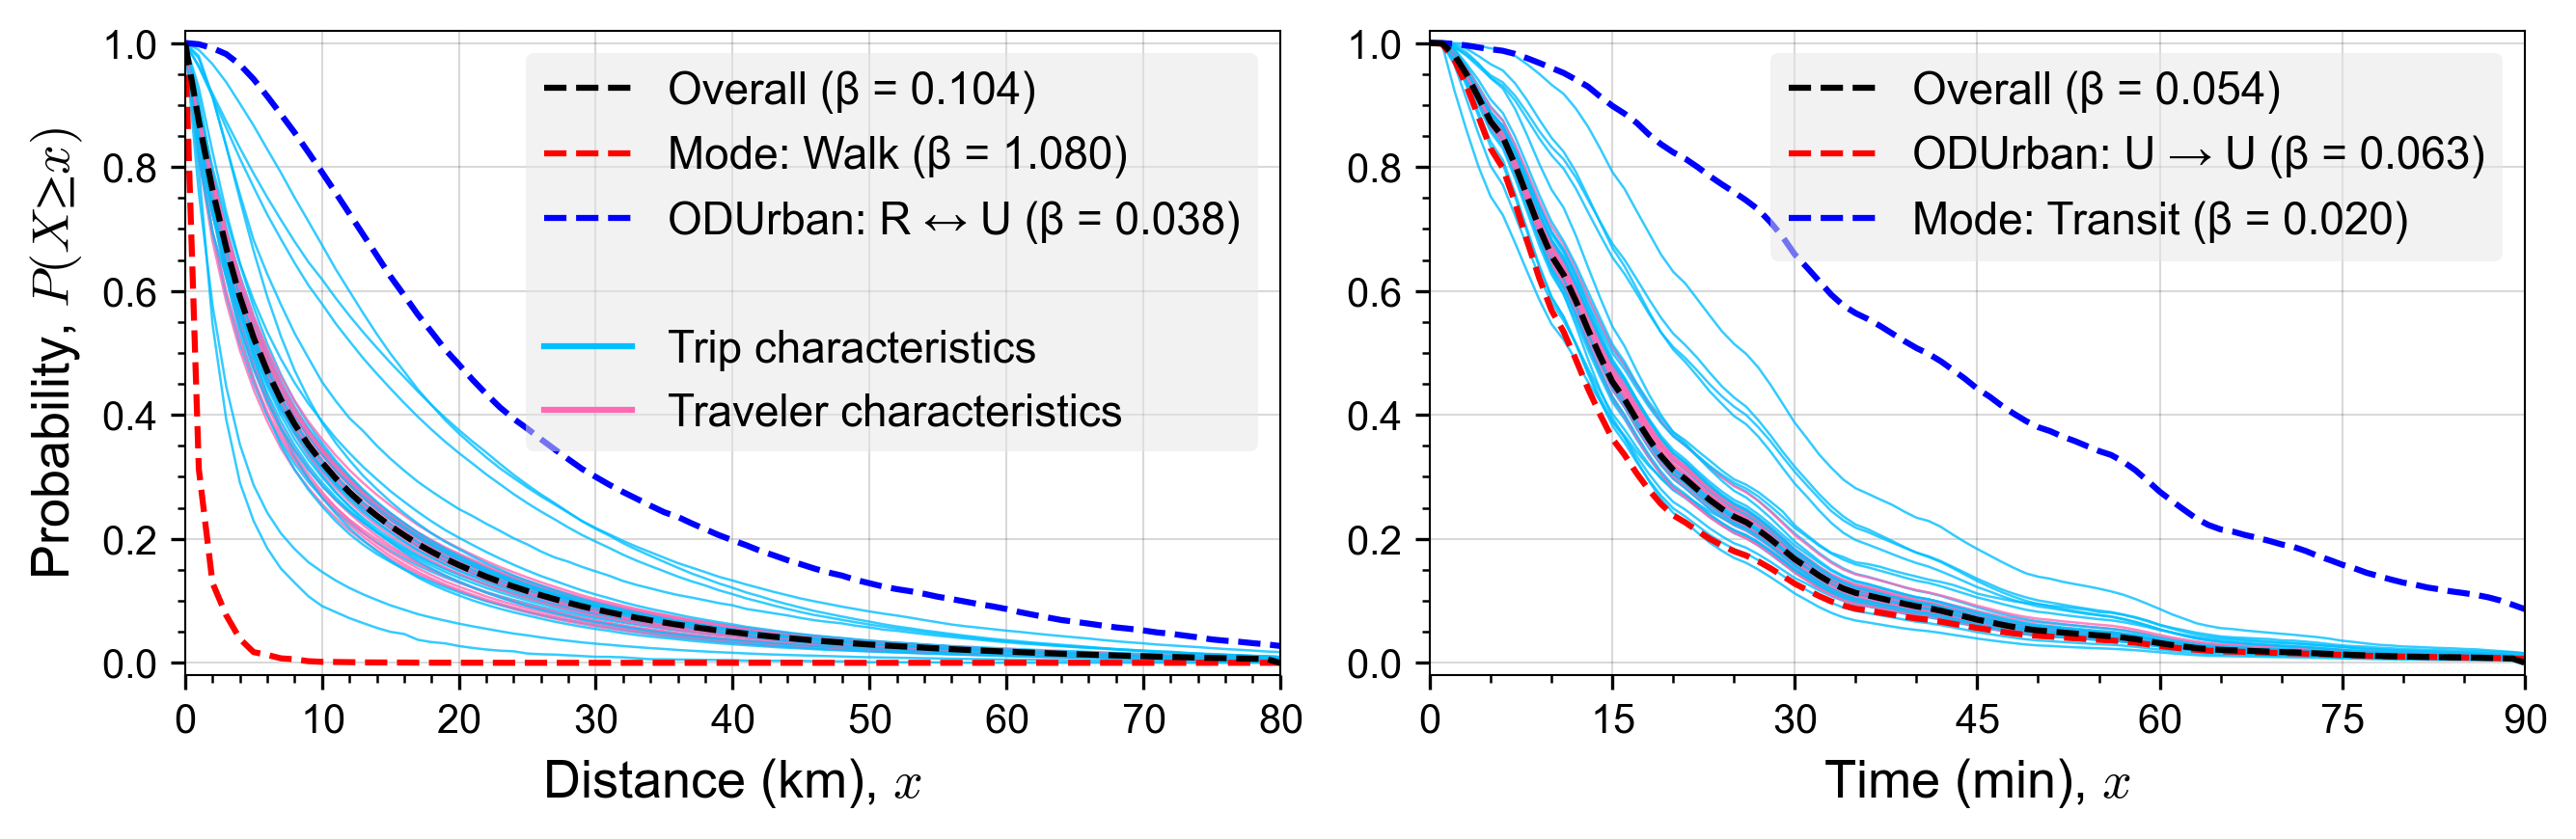

In [11]:
def fig_fitted_curves(fitted=fitted, hists=var_hist, groups=col_groups,
                      trips=trips, size=(9, 3), dpi=150):
    fit = (fitted.query('func=="Base exponential"')
           .explode('params').rename(columns=D(params='beta'))
           .merge(groups[['factor', 'color']]))
    fit.factor = ordered_factor(fit.factor)
    fit.level = ordered_factor(fit.level)
    fit['x'], fit['y'] = fit.factor.cat.codes, -fit.beta
    fit['label'] = fit.level.map(D(sum([
        [(z, i +1) for i, z in enumerate(df.level.unique())]
        for _, df in fit.groupby('factor')], [])))
    line = lambda label, **kw: mpl.lines.Line2D([0], [0], label=label, **kw)
    _, axes = plt.subplots(1, 2, figsize=size, dpi=dpi)
    for j, target, vmax, xlab in [(0, 'Distance', 80, 'Distance (km)'),
                                  (1, 'Time', 90, 'Time (min)')]:
        Y, X = np.histogram(trips[target].clip(0, vmax), bins=np.arange(0, vmax + 1))
        Y = (1 - (Y / Y.sum()).cumsum()).clip(0)
        beta = -curve_fit(lambda x, b: np.exp(b * x), X[1:], Y)[0][0]
        lgd = [line(f'Overall (β = {beta:.3f})', color='k', ls='--')]
        ax = pplot(axes[j], xlim=(0, vmax), ylim=(-0.02, 1.02), xlab=f'{xlab}, $x$',
                   ylab='Probability, $P(X≥x)$' if j == 0 else '')
        df = hists.query(f'target=="{target}"')
        df = df.merge(fit[['target', 'factor', 'level', 'beta', 'color']])
        df = df.sort_values('beta').reset_index(drop=1)
        for _, r in df.iloc[1:-1].iterrows():
            ax.plot([0] + list(r.x), [1] + list(r.y), color=r.color, lw=0.6, alpha=0.8)
        for r, color in zip([df.iloc[0], df.iloc[-1]], ['r', 'b']):
            label = f'{r.factor}: {r.level} (β = {-r.beta:.3f})'
            lgd += [line(label, color=color, ls='--')]
            ax.plot([0] + list(r.x), [1] + list(r.y), color=color, lw=1.5, ls='--')
        ax.plot(X, [1] + list(Y), '--k', lw=1.5)
        if target == 'Time':
            ax.set_xticks(np.arange(0, 91, 15))
            ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
        if j == 0:
            lgd += [line('', color='none')]
            for _, r in groups.drop_duplicates(subset=['group']).iterrows():
                lgd += [line(r.group + ' characteristics', color=r.color)]
        ax.legend(handles=lgd)
    plt.subplots_adjust(wspace=0.1)
    plt.tight_layout()

x = fig_fitted_curves(dpi=300); x

## 4.3. Compare beta parameters

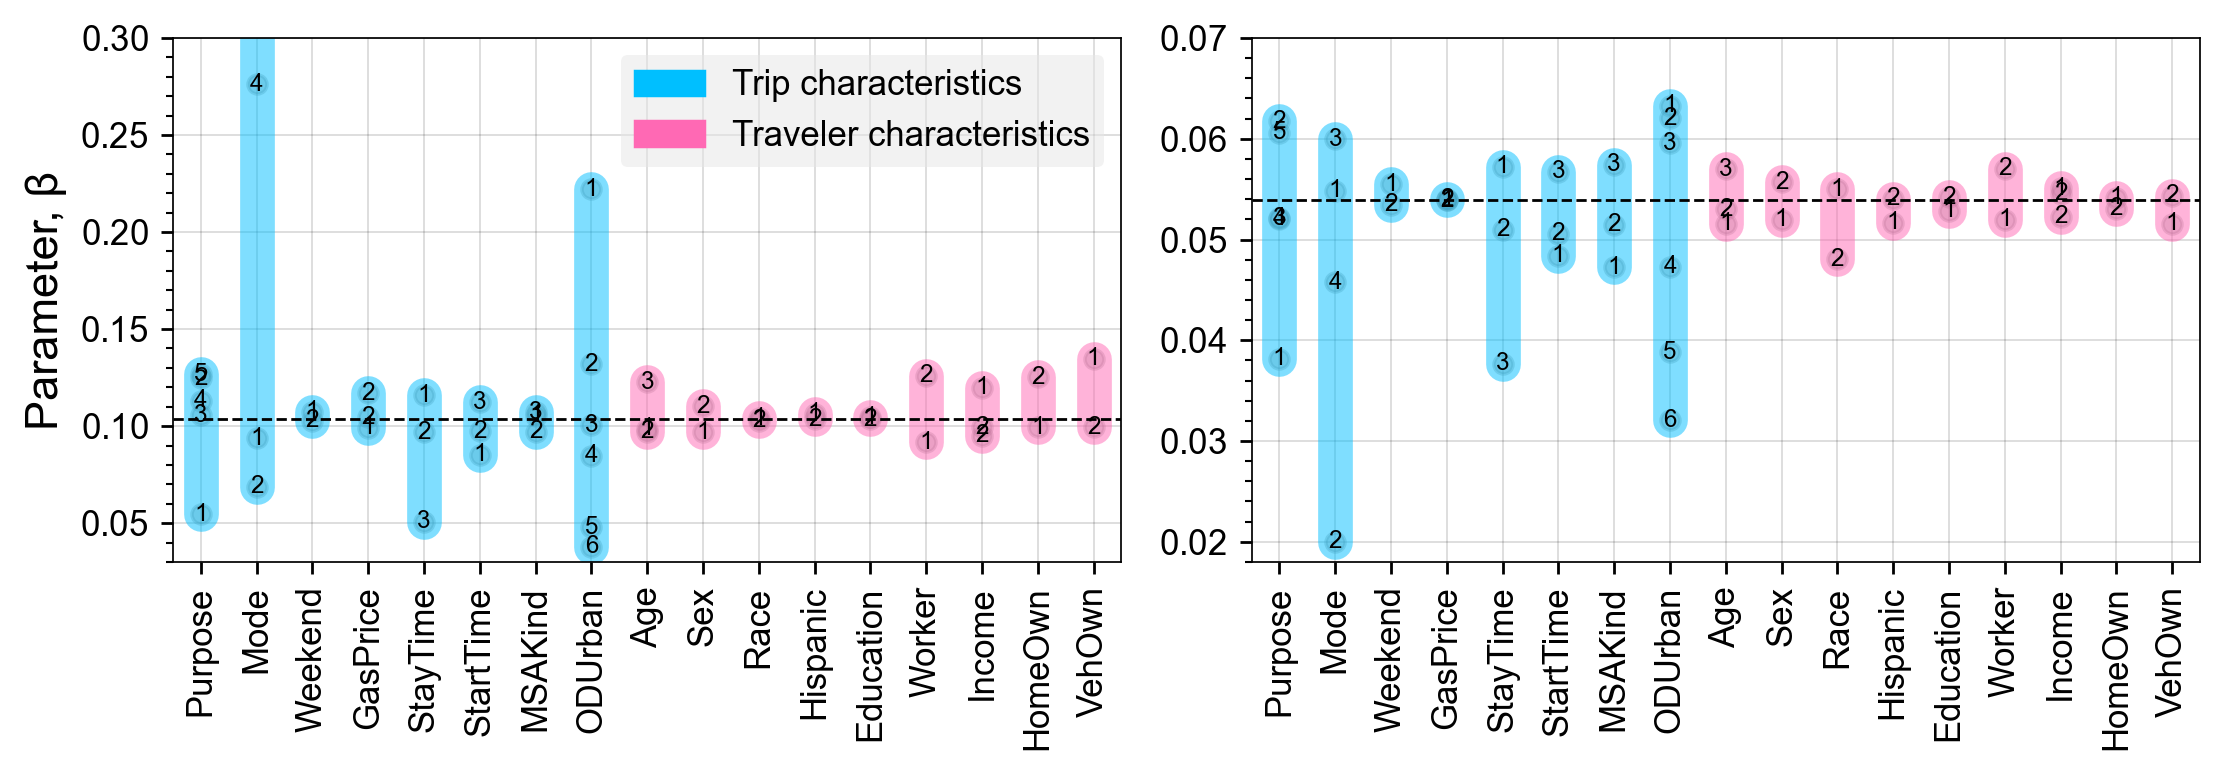

In [12]:
def fig_compare_betas(fitted=fitted, hists=var_hist, grps=col_groups,
                      trips=trips, size=(9, 3.2), dpi=150):
    fit = fitted.query('func=="Base exponential"').explode('params')
    hists = hists.merge(grps, on='factor')
    fit = fit.merge(grps, on='factor').rename(columns=D(params='beta'))
    fit.factor = ordered_factor(fit.factor)
    fit.level = ordered_factor(fit.level)
    fit['x'], fit['y'] = fit.factor.cat.codes, -fit.beta
    fit['label'] = fit.level.map(D(sum([
        [(z, i +1) for i, z in enumerate(df.level.unique())]
        for _, df in fit.groupby('factor')], [])))
    _, axes = plt.subplots(1, 2, figsize=size, dpi=dpi)
    for j, target, vmax, ymin, ymax, xlab in [
            (0, 'Distance', 80, 0.03, 0.3, 'Distance (km)'),
            (1, 'Time', 90, 0.018, 0.07, 'Travel time (min)')]:
        Y, X = np.histogram(trips[target].clip(0, vmax), bins=np.arange(0, vmax + 1))
        Y = (1 - (Y / Y.sum()).cumsum()).clip(0)
        beta = -curve_fit(lambda x, b: np.exp(b * x), X[1:], Y)[0][0]
        df = hists.query(f'target=="{target}"')
        df = df.merge(fit[['target', 'factor', 'level', 'beta']])
        df = df.sort_values('beta').reset_index(drop=1)
        ax = pplot(axes[j], xminor=0, xlim=(-0.5, fit.x.max() + 0.5),
                   ylim=(ymin, ymax), ylab='Parameter, β' if j == 0 else '')
        df1 = fit.query(f'target=="{target}"')
        for (_, color), df in df1.groupby(['factor', 'color']):
            x = df.x.iloc[0]
            ax.scatter(df.x, df.y, s=30, alpha=0.3, color='grey')
            ax.plot([x, x], [df.y.min(), df.y.max()], lw=10,
                color=color, alpha=0.5, solid_capstyle='round')
            for _, r in df.iterrows():
                if r.y > ymax: continue
                ax.text(x, r.y, str(r.label), fontsize=7, ha='center', va='center')
        ax.axhline(beta, ls='--', color='k', lw=0.8)
        ax.set_xticks(fit.x.unique(), fit.factor.cat.categories, rotation=90)
        if j == 0:
            ax.legend(fontsize=10, handles=[
                mpl.patches.Patch(label=k + ' characteristics', color=v) for k, v in
                grps.groupby(['group', 'color'], sort=False).size().index])
    plt.subplots_adjust(wspace=0.1)
    plt.tight_layout()

x = fig_compare_betas(dpi=250); x

# 5. SES factors

In [13]:
trips['SES'] = 'Mid'
trips.loc[trips.pipe(lambda df: (
    + (df.Age == 'Senior').astype(int)
    + (df.Worker == 'No').astype(int)
    + (df.Race == 'Non-White').astype(int)
    + (df.Income == 'Low').astype(int)
    + (df.HomeOwn == 'Rent').astype(int)
    + (df.VehOwn == 'Low').astype(int)
) >= 5), 'SES'] = 'Low'
trips.loc[trips.pipe(lambda df: (
    + (df.Age.isin(['Young', 'Mid'])).astype(int)
    + (df.Worker == 'Yes').astype(int)
    + (df.Race == 'White').astype(int)
    + (df.Income.isin(['Mid', 'High'])).astype(int)
    + (df.HomeOwn == 'Own').astype(int)
    + (df.VehOwn.isin(['Mid', 'High'])).astype(int)
) >= 5), 'SES'] = 'High'
trips.SES = pd.Categorical(trips.SES, categories=['Low', 'Mid', 'High'])
trips.SES.value_counts()

SES
High    398603
Mid     333528
Low      14957
Name: count, dtype: int64

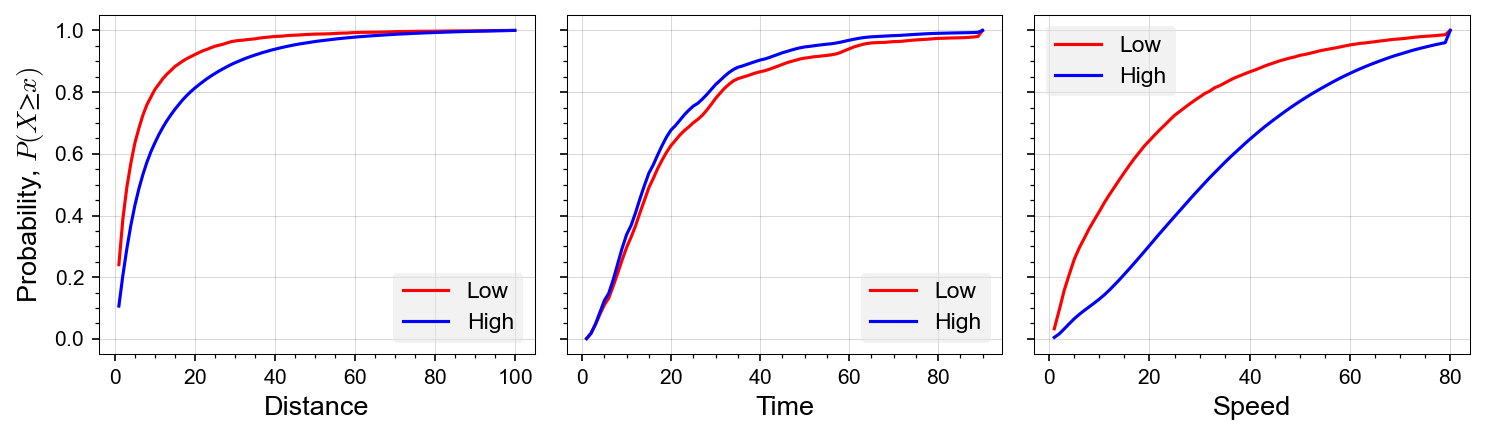

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), dpi=150, sharey=True)
for i, target, vmax in [(0, 'Distance', 100), (1, 'Time', 90), (2, 'Speed', 80)]:
    ax = pplot(axes[i], xlab=target, ylab='Probability, $P(X≥x)$' if i == 0 else '')
    for lab, color in [('Low', 'r'), ('High', 'b')]:
        y = trips.query(f'SES=="{lab}"')[target].clip(0, vmax)
        y, x = np.histogram(y, bins=np.arange(0, vmax+1))
        ax.plot(x[1:], (y / y.sum()).cumsum(), label=lab, color=color)
    ax.legend()
plt.tight_layout()

# 6. Finalize factors

In [15]:
trips2 = trips.copy()
trips2['LongStay'] = ordered_factor((trips.StayTime == 'Long').map({True: 'Yes', False: 'No'}))
trips2['Purpose'] = trips2.Purpose.map(D(
        HBW='Work', HBSHOP='Shopping', HBSOC='Other', HBO='Other'))
trips2 = trips2.query('ODUrban != "R ↔ U"').dropna().reset_index(drop=1)
trips2.ODUrban = trips2.ODUrban.cat.remove_unused_categories()
trips2.Purpose = pd.Categorical(trips2.Purpose, categories=['Work', 'Shopping', 'Other'])
trips2 = trips2[['Distance', 'Time', 'Speed', 'Mode', 'Purpose', 'LongStay', 'ODUrban', 'SES']].disp()
trips2.to_parquet('../data/trips2.parquet')

477,550 rows x 8 cols; Memory: 13.2 MiB


Distance       Time      Speed        Mode     Purpose    LongStay  \
   <float64>  <float64>  <float64>  <category>  <category>  <category>   
0   8.439379  16.182075  31.291583       Drive       Other          No   

      ODUrban         SES  
   <category>  <category>  
0       S → S         Mid

  0%|          | 0/3 [00:00<?, ?it/s]

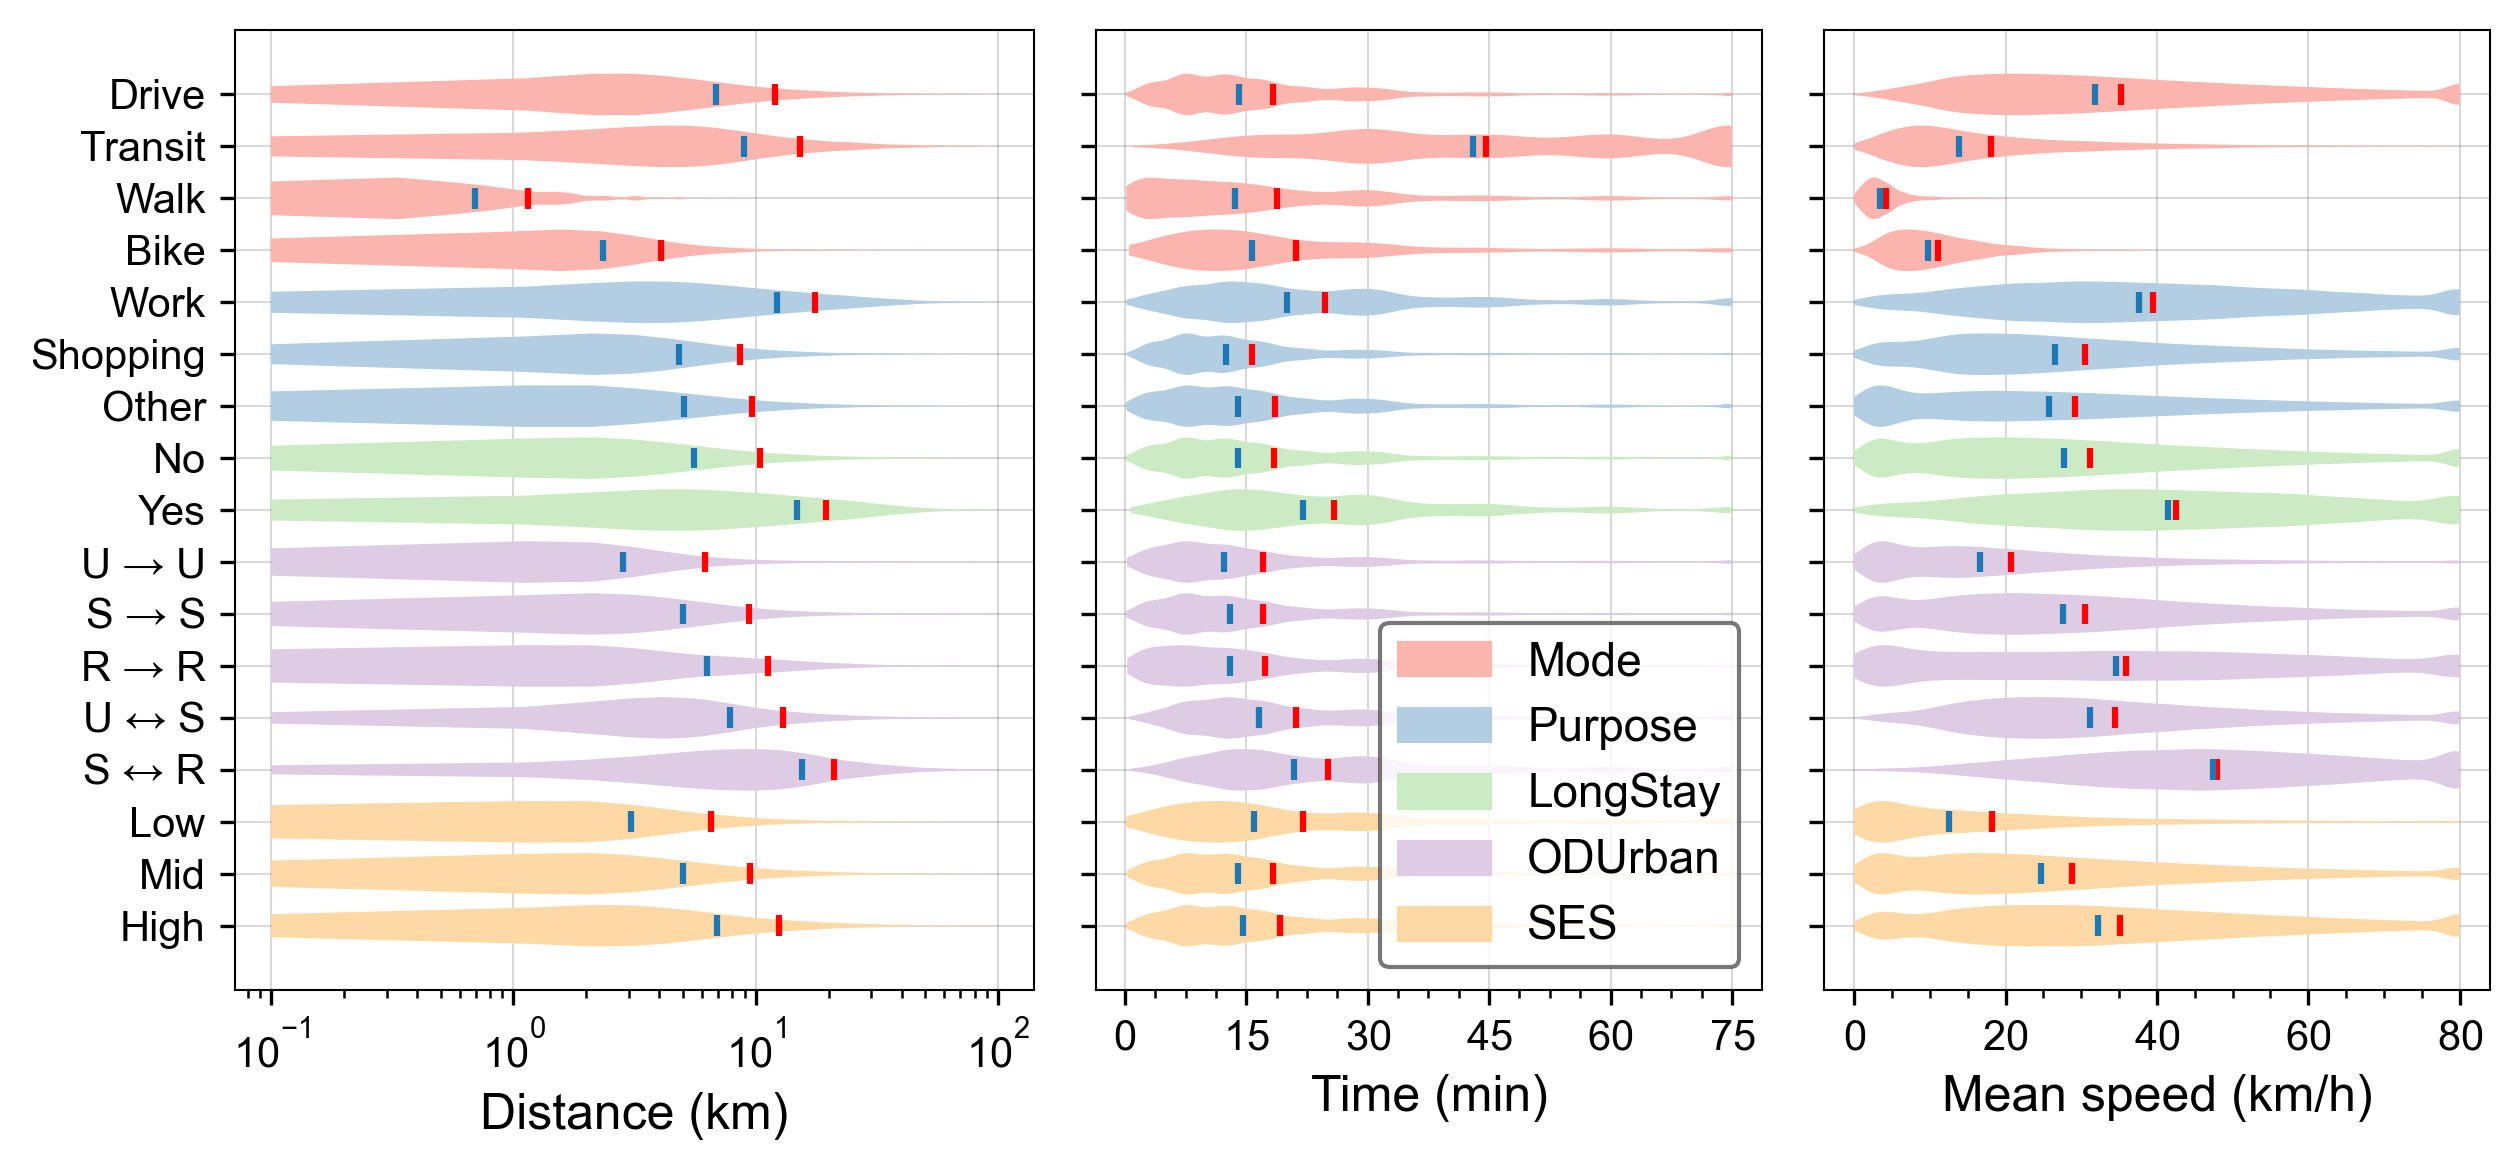

In [56]:
def fig_final_vars_distr(trips=trips2, dpi=150, cmap='Pastel1'):
    _, axes = plt.subplots(1, 3, figsize=(8.5, 4), dpi=dpi,
                           gridspec_kw=D(width_ratios=[1.2, 1, 1]))
    ticker = mpl.ticker.EngFormatter(places=1)
    factors = list(trips.select_dtypes(CAT).columns)
    colors = sns.color_palette(cmap, len(factors)).as_hex()
    for j, (var, label, rng) in enumerate(tqdm([
            ('Distance', 'Distance (km)', (0.1, 100)),
            ('Time', 'Time (min)', (0, 75)),
            ('Speed', 'Mean speed (km/h)', (0, 80))])):
        df = Pdf(sum([[D(col=col, cat=x[0], vals=x[1].values, n=ticker(len(x[1])))
                       for x in trips.groupby(col)[var]] for col in factors], []))
        df.vals = [x.clip(*rng) for x in df.vals]
        df['color'] = df.col.map(D(zip(factors, colors)))
        ax = pplot(axes[j], xlog=var == 'Distance', yminor=0)
        ax.set_xlabel(label, fontsize=12)
        x = ax.violinplot(list(df.vals), positions=np.arange(len(df)),
                          vert=False, widths=0.8,
                          showextrema=False, showmeans=True, showmedians=True)
        for line, color in zip(x['bodies'], df.color):
            line.set_alpha(1)
            line.set_facecolor(color)
            line.set_linewidth(0)
        x['cmeans'].set_edgecolor('r')
        ax.invert_yaxis()
        ax.set_yticks(np.arange(len(df)), df.cat)
        if var == 'Time': ax.set_xticks(np.arange(0, 75+1, 15))
        if j != 0: ax.set_yticklabels([])
        if j == 1:
            ax.legend(handles=[mpl.patches.Patch(label=f, color=c)
                               for f, c in zip(factors, colors)],
                      loc=4, framealpha=0.8, facecolor='w', edgecolor='#555')
    plt.tight_layout()
    imsave('Distributions of finalized variables')

x = fig_final_vars_distr(dpi=300, cmap='Pastel1'); x # t=0:23

## 6.1. Correlation

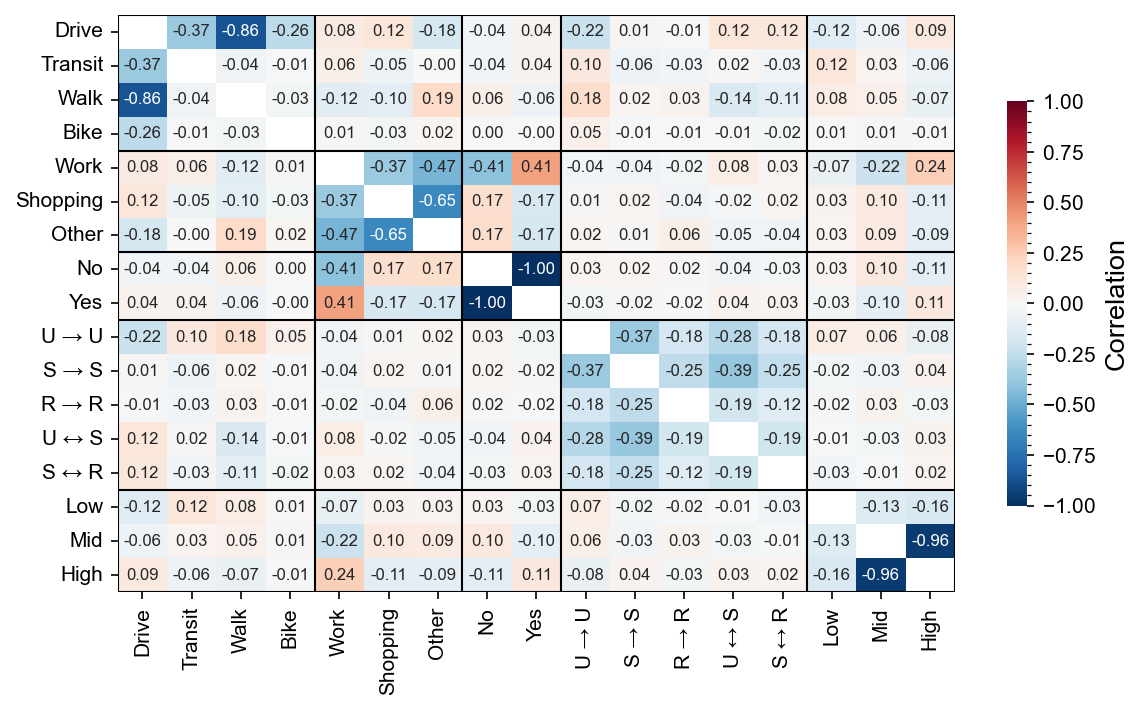

In [23]:
def plot_corr_final_vars(trips=trips2, size=(9, 5), dpi=150, cmap='RdBu_r'):
    X = pd.get_dummies(trips.select_dtypes(CAT), prefix_sep='__')
    corr = X.corr()
    np.fill_diagonal(corr.values, np.nan)
    ax = pplot(size=size, dpi=dpi, xminor=0, yminor=0, gridcolor='#ffff')
    labels = [x.split('__')[1] for x in X.columns]
    ax = sns.heatmap(corr, ax=ax, cmap=cmap, vmin=-1, vmax=1,
                     xticklabels=labels, yticklabels=labels,
                     cbar=True, cbar_kws=D(shrink=0.7, label='Correlation'),
                     annot=True, fmt='.2f', annot_kws=D(fontsize=8))
    cols = Pdf(D(col=X.columns))
    cols['feat'] = cols.col.str.split('__').str[0]
    cols['idx'] = (cols.feat.astype(CAT).cat.codes.diff() != 0)
    for x in list(cols.idx[cols.idx].index) + [len(cols)]:
        ax.axvline(x, color='k', lw=1)
        ax.axhline(x, color='k', lw=1)

x = plot_corr_final_vars(dpi=150); x

## 6.2. Parameters

In [62]:
var_hist2 = get_var_hist(trips2).disp()

34 rows x 5 cols; Memory: 0.0 MiB


target    factor     level  \
   <object>  <object>  <object>   
0  Distance      Mode     Drive   

                                                   x  \
                                            <object>   
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                                   y  
                                            <object>  
0  [0.9511535959161204, 0.8586514331472042, 0.764...

In [66]:
fitted2 = fit_decay_functions({k: v for k, v in imped_funcs.items() if k in [
    'Base exponential', 'Power exponential']}, hists=var_hist2).disp()

68 rows x 6 cols; Memory: 0.0 MiB


target    factor     level              func         r2  \
   <object>  <object>  <object>          <object>  <float64>   
0  Distance      Mode     Drive  Base exponential    0.99011   

                   params  
                 <object>  
0  [-0.08911207410424227]

In [75]:
df = (fitted2.assign(factor=lambda df: ordered_factor(df.factor),
                     level=lambda df: ordered_factor(df.level)))
df['coef'] = [[f'β{i+1}' for i in range(len(x))] for x in df.params]
df = df.explode(['coef', 'params'])
df.loc[(df.func=='Base exponential') & (df.coef=='β1'), 'params'] *= -1
df.pivot_table('params', ['factor', 'level'], ['target', 'func', 'coef'])

target                    Distance                              \
func              Base exponential Power exponential             
coef                            β1                β1        β2   
factor   level                                                   
Mode     Drive            0.089112          0.122854  0.877197   
         Transit          0.068776          0.088524  0.912365   
         Walk             0.931164          1.009143   0.81148   
         Bike               0.2805          0.308049  0.934004   
Purpose  Work             0.056338          0.054657  1.009745   
         Shopping         0.129474          0.171907  0.872209   
         Other             0.11579          0.196774  0.776508   
LongStay No               0.105491          0.171003  0.803579   
         Yes              0.050107          0.034814  1.113264   
ODUrban  U → U            0.200157            0.3337  0.714865   
         S → S            0.119269           0.18546  0.809597   
         R → R            0.094564          0.168908   0.77848   
         U ↔ S            0.081358          0.086585  0.976746   
         S ↔ R            0.047068           0.02409  1.207976   
SES      Low              0.178135          0.311009  0.715149   
         Mid              0.117991          0.188794  0.799718   
         High             0.085163          0.133613  0.832236   

target                        Time                              
func              Base exponential Power exponential            
coef                            β1                β1        β2  
factor   level                                                  
Mode     Drive            0.053496          0.015991  1.393807  
         Transit          0.019046           0.00089  1.762914  
         Walk             0.052079          0.043749  1.055079  
         Bike             0.046377          0.019561  1.269444  
Purpose  Work             0.038678          0.008891  1.431395  
         Shopping         0.062813          0.015266  1.489987  
         Other            0.053054          0.021487  1.293076  
LongStay No               0.053353          0.019558    1.3268  
         Yes              0.036958           0.00519  1.569844  
ODUrban  U → U            0.058593          0.030422  1.220623  
         S → S            0.057892          0.021859  1.325778  
         R → R            0.056998          0.031023  1.200436  
         U ↔ S            0.046155          0.009398  1.498489  
         S ↔ R            0.038323          0.004624  1.624037  
SES      Low              0.044214          0.022341  1.208987  
         Mid              0.053793          0.018998  1.340254  
         High             0.050836          0.018514  1.322815